## **ARIMA MODELS** 

**Understanding AR, I, and MA Components** 

- **Autoregressive (AR):** Relies on the relationship between an observation and a number of lagged observations.
- **Integrated (I):** Involves differencing the observations to make the series stationary, removing trends and seasonality.
- **Moving Average (MA):** Models the error of the series as a combination of past errors and lagged observations.

**Selecting Appropriate ARIMA Models**

- **Description:** ARIMA combines AR, I, and MA components to fit data that exhibits trends and seasonality, making it powerful for forecasting non-stationary time series once they have been differenced to stationarity.

- **Use Case:** Best for detailed time series analysis where data behavior changes over time due to underlying trends and cycles.

**Steps in notebook**

- Split the data into training and testing sets.
- Checks for stationarity in the original and differenced time series using the Augmented Dickey-Fuller test.
- Implements a manual ARIMA model with specified parameters.
- Uses auto_arima to automatically select the best ARIMA parameters.
- Performs a grid search to find the best ARIMA parameters based on AIC.
- Evaluate the performance of each ARIMA model.
- Plot the actual stock prices for the last 30 days along with the 10-day forecasts from each ARIMA method.

In [42]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Download stock data
ticker = "AAPL"  # Apple Inc. as an example
end_date = datetime.now()
start_date = end_date - timedelta(days=365*5)  # 5 years of data
data = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
# Prepare the data
ts = data['Close'].astype(float)

**Split the data into training and testing sets**

In [9]:
# Split the data into training and testing sets
train_size = int(len(ts) * 0.8)
train, test = ts[:train_size], ts[train_size:]

print(f"Training set size: {len(train)}")
print(f"Testing set size: {len(test)}")

Training set size: 1004
Testing set size: 252


**Check for stationarity**

In [10]:
# Function to check stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

print("Stationarity Check for Training Series:")
check_stationarity(train)

Stationarity Check for Training Series:
ADF Statistic: -1.2785339876939128
p-value: 0.6389349337140321
Critical Values:
	1%: -3.436893045520188
	5%: -2.8644287878535146
	10%: -2.568308127138936


The p-value: 0.6389349337140321 is greater than 0.05, so we fail to reject the null hypothesis. This means that the time series is non-stationary.

Now we will try differencing the time series to make it stationary.

In [11]:
# Differencing if necessary
train_diff = train.diff().dropna()
print("\nStationarity Check for Differenced Training Series:")
check_stationarity(train_diff)


Stationarity Check for Differenced Training Series:
ADF Statistic: -33.51650530000512
p-value: 0.0
Critical Values:
	1%: -3.436893045520188
	5%: -2.8644287878535146
	10%: -2.568308127138936


The p-value: 0.0 is less than 0.05, so we reject the null hypothesis. This means that the time series is stationary.

We will now continue on to the manual ARIMA model.

**Once we difference the data the models will be fit to the differenced data, so its important that after forecast we reverse the differencing to get the forecast in the original scale.**

In [27]:
# Function to revert differencing
def revert_differencing(original_series, differenced_forecast):
    reverted_forecast = []
    last_original_value = original_series.iloc[-1]  # Last value from the original series

    # Revert differencing by adding the forecasted difference to the last original value
    for forecast in differenced_forecast:
        next_value = last_original_value + forecast
        reverted_forecast.append(next_value)
        last_original_value = next_value

    return pd.Series(reverted_forecast, index=differenced_forecast.index)

## **Manual ARIMA Model**

In [28]:
# Manual ARIMA
def manual_arima(train_diff, test, order=(1,1,1)):  # Example ARIMA(p,d,q) order
    model = ARIMA(train_diff, order=order).fit() #  Fit ARIMA model manually 
    forecast = model.forecast(steps=len(test)) # Forecasting the same length as the test set
    return forecast

manual_forecast = manual_arima(train_diff, test)
forecast_original_scale = revert_differencing(train, manual_forecast)
print("\nManual ARIMA(1,1,1) Forecast:")
print(forecast_original_scale)


Manual ARIMA(1,1,1) Forecast:
1003    196.570635
1004    196.719772
1005    196.867282
1006    197.014886
1007    197.162484
           ...    
1250    233.028860
1251    233.176459
1252    233.324057
1253    233.471655
1254    233.619253
Length: 252, dtype: float64


## **AUTO ARIMA**

In [36]:

# Auto ARIMA
def auto_arima_forecast(train_diff, test):
    model = auto_arima(train_diff, seasonal=False, suppress_warnings=True)
    forecast = model.predict(n_periods=len(test))
    return forecast

auto_forecast = auto_arima_forecast(train_diff, test)
auto_forecast_original_scale = revert_differencing(train, auto_forecast)
print("\nAuto ARIMA Forecast:")
print(auto_forecast_original_scale)


Auto ARIMA Forecast:
1003    196.558771
1004    196.706351
1005    196.853931
1006    197.001511
1007    197.149091
           ...    
1250    233.011025
1251    233.158605
1252    233.306184
1253    233.453764
1254    233.601344
Length: 252, dtype: float64


## **Grid Search to find the best ARIMA parameters**

In [37]:
# Grid Search for best ARIMA parameters
def grid_search_arima(ts, p_range, d_range, q_range):
    best_aic = float("inf")
    best_params = None
    for p, d, q in product(p_range, d_range, q_range):
        try:
            model = ARIMA(ts, order=(p, d, q)).fit()
            if model.aic < best_aic:
                best_aic = model.aic
                best_params = (p, d, q)
        except Exception as e:  # Log the exception for debugging
            print(f"Error with ARIMA({p},{d},{q}): {e}")
            continue
    return best_params

best_params = grid_search_arima(train_diff, range(0, 3), range(0, 2), range(0, 3))
print(f"\nBest ARIMA Parameters: {best_params}")


Best ARIMA Parameters: (0, 0, 1)


## **Use the best ARIMA Parameters to fit the model**

In [38]:
best_forecast = manual_arima(train_diff, test, order=best_params)
best_forecast_original_scale = revert_differencing(train, best_forecast)
print("\nBest ARIMA Model Forecast:")
print(best_forecast_original_scale)


Best ARIMA Model Forecast:
1003    196.558793
1004    196.706391
1005    196.853989
1006    197.001587
1007    197.149185
           ...    
1250    233.015494
1251    233.163092
1252    233.310690
1253    233.458288
1254    233.605886
Length: 252, dtype: float64


## **Evaluate the performance of each ARIMA model**

In [39]:
# Evaluation metrics
def evaluate_forecast(actual, forecast):
    mse = mean_squared_error(actual, forecast)
    rmse = math.sqrt(mse)
    mae = mean_absolute_error(actual, forecast)
    return mse, rmse, mae

print("\nEvaluation Metrics:")
print("Manual ARIMA(1,1,1):")
mse, rmse, mae = evaluate_forecast(test, forecast_original_scale)
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

print("\nAuto ARIMA:")
mse, rmse, mae = evaluate_forecast(test, auto_forecast_original_scale)
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")

print("\nBest ARIMA:")
mse, rmse, mae = evaluate_forecast(test, best_forecast_original_scale)
print(f"MSE: {mse:.2f}, RMSE: {rmse:.2f}, MAE: {mae:.2f}")


Evaluation Metrics:
Manual ARIMA(1,1,1):
MSE: 976.33, RMSE: 31.25, MAE: 28.17

Auto ARIMA:
MSE: 975.45, RMSE: 31.23, MAE: 28.16

Best ARIMA:
MSE: 975.58, RMSE: 31.23, MAE: 28.16


## **Plot the predictions against the test data**

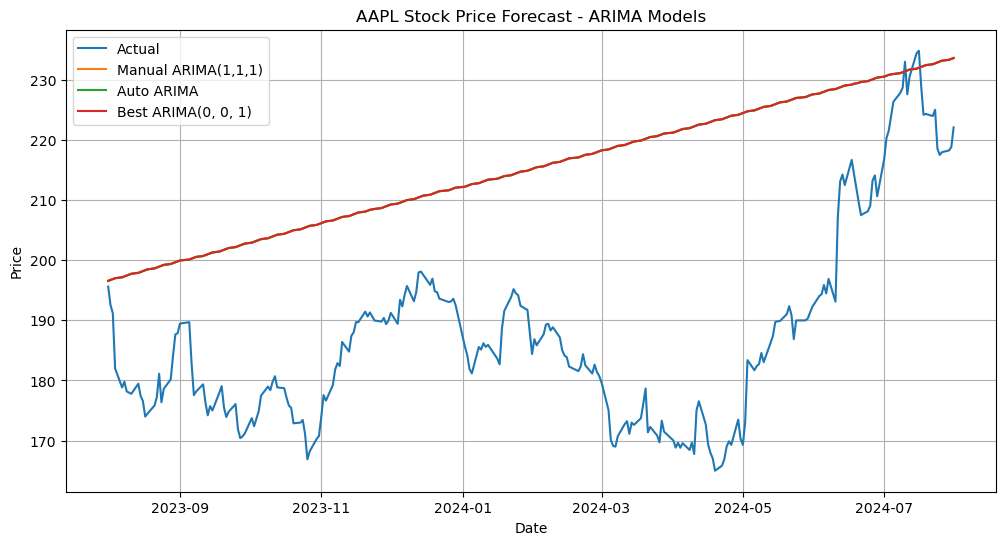

In [40]:
# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_original_scale, label='Manual ARIMA(1,1,1)')
plt.plot(test.index, auto_forecast_original_scale, label='Auto ARIMA')
plt.plot(test.index, best_forecast_original_scale, label=f'Best ARIMA{best_params}')
plt.title(f'{ticker} Stock Price Forecast - ARIMA Models')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

## **Analysis of Results from Metrics and Plots**

The models do not perform well on the data.  We are going to try some more advanced ARIMA models. 

Financial data is very noisy and hard to predict.  We will try to use a more advanced models in the next notebook.

